NNota para antes de leer este documento:<br>
<b><i> 1. El paquete dst contiene toda la implementacion de las ideas aqui expuestas. EL notebook 2. Implementacion incluye implementaciones para distintas configuraciones. En el presente documento se expondra codigo de manera ilustrativa, sin embargo, el paquete es el encargado de relizar los procedimientos aqui expuestos. Para ver la implementacion puede dirigirse al codigo fuente, al enlace a colab o al notebook de experimentos. </i></b>
<br><br>
<b><i> 2. La implementacion que se realizo se basa en el documento  <a href= "https://www.cvfoundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf">Image Style Transfer Using Convolutional Neural Networks</a>, en el <a href="https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398">blog de tensorflow </a>y en el <a href="https://markojerkic.com/style-transfer-keras/">blog de Marko Jerkic</a></i></b>
<br><br>
<b><i> 3. La implementacion esta escrita en python3 usando tensorflow y keras</i></b>


In [1]:
# from dts import load_images
import sys
sys.path.append("..")
import dst
import dst.tools as tools
import numpy as np

import dst.losses as losses
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow import keras
from tensorflow.python.keras import models

import IPython.display

from PIL import Image
import time

K = keras.backend

<h1 style="width: 100%;text-align:center;"> Implementacion de la tecnica de transferencia de estilo  </h1>
<p style="width: 100%;text-align:center;">  Universidad de Antioquia <br> Angelower Santana Velasquez <br> Martin Elias Quintero  Osorio</p>


En primer lugar necesitamos una red neural pre-entrenada. Luego congelaremos la red dado que no vamos a realizar ningun entrenamiento en el proceso. La idea detras de usar la red ya entrenada es usar sus filtros,los cuales, ya aprendieron ciertos patrones y comportamientos a partir del conjunto de datos.

Keras provee varias redes de este estilo entrenadas con una base de datos enorme llamada <b>Imagenet</b>. En el paquete dst se usa la vgg19.

In [2]:
def _get_vgg19():
    ''' Get pre-trained(ImageNet) VGG19 Model without classifier.
        Return:
              vgg19 model(Keras)
    '''
    vgg19 = keras.applications.vgg19.VGG19(
        weights='imagenet',  include_top=False)
    return vgg19

Notemos que uno de los parametros que ofrece el modulo <i>keras.applications.vgg19.VGG19</i> es <b>"include_top"</b>. Si este parametro lo asignamos Falso, solo nos devolvera los modulos convolcionales de la red. Es importante asignarle dicho valor para nuestros propositos debido a que no necesitamos el clasificador compuesto por capas densas, ademas, el peso en mb de la red decrementa considerablemente.

Congelar la red consta de recorrer las capas de vgg19 y asignar como un valor de falso al parametro que determina si la capa es entrenable o no.

In [3]:
def freeze_layers(model):
    """Freeze layers in the model
        Args:
            model: Model
    """
    for layer in model.layers:
        layer.trainable = False
    return model


Al entrenar una red neuronal con imagenet debes saber que esta puede tardar semana en terminar con el proceso de entrenamiento. Es por eso que la comunidad de codigo libre comparte los pesos para que otras personas utilicen las redes pre-entrenadas para ciertos propositos, generalmente, transfer learning y fine-tunning. Nosotros de cierta forma estamos realizando transfer learning.

El modelo que provee Keras de vgg19 fue originalmente entrenado en el framework Caffe. Por eso debemos realizar un par de metodos adicionales para realicar un procesamiento previo de las imagenes y asi sean correctas para ingresarlas a la red. Vgg19 de Caffe recibe la imagen en formato BGR y a cada pixel se le resta la media. Keras proporciona una forma sencilla de realizar esto con <i>keras.applications.vgg19.preprocess_input</i>

In [4]:
def _load_and_process_img(path_image, max_dim=512, url=False):
    ''' Load image(open, scale, convert in numpy array and add batch dim to
         image) and preprocess image in the VGG format. (Color format BGR and 
         normalize pixels with the mean)

        Arg:
            path_image(str): Source address where the image is located
            max_dim: Maximun dimension of the image(Scale Relative)
        Returns:
                image preprocess(VGG format)
    '''
    print("IMAGE URL", url)
    img = _load_image(path_image, max_dim, url=url)

    # Preprocess input image to vgg requierements
    # That is a normalize(central) pixel of image
    img = keras.applications.vgg19.preprocess_input(img)
    return img


Cargamos una imagen.

In [5]:
medellin_path = "../images/medellin.jpg"
van_gogh_path = "../images/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

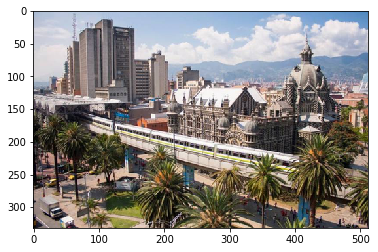

In [6]:
medellin = tools._load_image(medellin_path)
medellin = tools._del_dim(medellin)
plt.imshow((medellin))

Ahora la convertimos al formato de VGG19

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


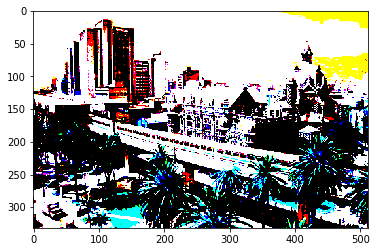

In [7]:
medellin_vgg_format = keras.applications.vgg19.preprocess_input(medellin)
plt.imshow((medellin_vgg_format))

Para invertir el proceso de conversion al formato VGG19, se suman los valores medios por dimension y se invierte los colores de BGR a RGB.

In [8]:
# Sumamos los valores medios a la imagen
medellin_vgg_format[:, :, 0] += 103.939
medellin_vgg_format[:, :, 1] += 116.779
medellin_vgg_format[:, :, 2] += 123.68

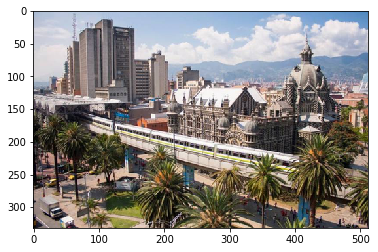

In [9]:
# Cambiamos el formato de BGR a RGB
medellin_vgg_format = medellin_vgg_format[:, :, ::-1]
# Cerramos los valores entre 0 y 255
medellin_vgg_format = np.clip(medellin_vgg_format, 0, 255).astype('uint8')
plt.imshow(medellin_vgg_format)

Este proceso completo con el paquete dst seria.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


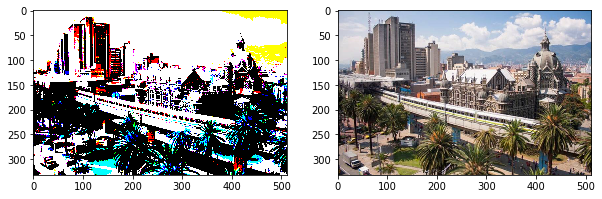

In [10]:
plt.figure(figsize=(10,10))

medellin_dst = dst.tools._load_and_process_img(medellin_path)
plt.subplot(1, 2, 1)
plt.imshow(tools._del_dim(medellin_dst))
medellin_dst_depro = dst.tools.deprocess_img(medellin_dst)
plt.subplot(1, 2, 2)
plt.imshow(medellin_dst_depro)

<h3> Modelo modificado</h3>

Miremos como obtenemos el modelo y modificamos un poco la red para nuestro proposito.

In [11]:
# Obtemos VGG
vgg = dst.dst._get_vgg19()


Instructions for updating:
Colocations handled automatically by placer.


In [12]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Ahora congelamos las capas, notemos como la salida del metodo summary en Trainable params cambia a 0.

In [13]:
dst.tools._freeze_layers(vgg).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Vamos a definir cuales son las capas de interes

In [14]:
CONTENT_LAYERS_LIST = ['block5_conv2']
STYLE_LAYERS_LIST = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1'
                     ]

Del modelo solo necesitamos hasta la capa block5_conv1, y las salidas del modelo deberia ser las capas que estan en CONTENT_LAYERS_LIST y STYLE_LAYERS_LIST

El output de cada una de las capas lo usaremos para determinar nuestro nuevo modelo.

In [15]:
style_outputs = [vgg.get_layer(name).output for name in STYLE_LAYERS_LIST]

In [16]:
content_outputs = [vgg.get_layer(name).output for name in CONTENT_LAYERS_LIST]

In [17]:
# Agregamos las dos salidas
model_outputs = style_outputs + content_outputs

Ahora podemos definir un nuevo modelo, donde la entrada sera una imagen igual que el modelo vgg19 pero la salida sera model_outputs

In [18]:
new_model = models.Model(vgg.input, model_outputs)

In [19]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Observemos que la cantidad de paramos redujo y ahora la ultima capa de la red es <b>block5_conv2</b>, correspondiente a la cada de donde vamos a extraer el contenido.

En el paquete dst este proceso seria :

In [20]:
new_model_dst = dst.dst.get_model(CONTENT_LAYERS_LIST, STYLE_LAYERS_LIST)
new_model_dst.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

<h3>Mapas de caracteristicas </h3>

Podemos ahora obtener los mapas de caracteristicas tanto para la imagen de estilo como para la imagen de contenido. En otras palabras, pasaremos por la red ambas imagenes y de cada una guardaremos las capas que es entan en CONTENT_LAYERS_LIST y STYLE_LAYERS_LIST respectivamente.

In [21]:
def _get_feactuere_maps(model, content_path, style_path, num_style_layers,
                        url=False):
    content_image = tools._load_and_process_img(content_path, url=url)
    style_image = tools._load_and_process_img(style_path, url=url)

    style_outputs = model(style_image)
    content_outputs = model(content_image)
    # La posicion de style_layer es 0 dado que es un tensor donde la primer dimension es el numero en el lote
    style_features = [style_layer[0]
                      for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0]
                        for content_layer
                        in content_outputs[num_style_layers:]]

    return style_features, content_features

In [22]:
style_features, content_features = dst.dst._get_feactuere_maps(new_model_dst, medellin_path, van_gogh_path, len(STYLE_LAYERS_LIST))
print("N. de capas de estilo: ",len(style_features))
print("N. de capas de contenido", len(content_features))



N. de capas de estilo:  5
N. de capas de contenido 1


El paramentro num_style_layers se utiliza para saber hasta que punto del arreglo que retorna el modelo corresponden las capas de estilo y contenido, recordemos que la salida del modelo esta dada por <i>model_outputs = style_outputs + content_outputs</i>, es decir que la salida es ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1', <b>'block5_conv2'</b>], estando la capa de contenido en la ultima posicion.

<h3>Matrices Gram</h3>

Ahora estamos listos para calcular las matrices gram por cada capa de estilo. Existen varias maneras de hacerlo, aunque, basicamente el calculo de la matriz se reduce a multiplicar una capa por su traspuesta. Acontinuacion se muestran dos versiones para calcular la matriz gram, una de este link y la otra de este link, optamos por usar la implementacion que se encuentra en el blog de tensorflow.

In [23]:
#  Blog de tensorflow.
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [24]:
# Version de blog markojerkic
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

De esta forma obtenemos dicha matriz para cada una de las capas de estilo de interes. Posteriormente se realizara el mismo tratamiento para las capas ,este vez, de la imagen generada.

Por ejemplo, para capturar las matrices gram de los mapas de caracteristicas de estilo seria : 


In [25]:
# Get Gram Matrix per each Style Layer
gram_style_features = [losses.gram_matrix(style_feature) for style_feature in style_features]
print("N. de matrices gram: ",len( gram_style_features))

N. de matrices gram:  5


Estas matrices gram son de la imagen de estilo, por tanto podemos guardarlas en memoria y sera el estilo objetivo de las matrices gram de la imagen generada.

<h3>Imagen Generada, Eager execution e imagen en variables </h3>

Recordemos que no vamos a realizar un entrenamiento comun y corriente.. Orginalmente, el diseno de tensorflow estaba destinada a la computacion por flujo. Es decir, se creaba un grafo computacional tal que luego de armar las operaciones de dicho grafo se compila y se ejecuta mendiante un flujo de datos. Algunos datos pueden ser alimentados en tiempo de ejecucion, mientras otros son aprendidos y modificados en el mismo proceso de optimizacion del grafo computacional. En la version 1.7 de Tensorflow se incluyo una nueva caracteristica llamada <b>Eager Execution</b>, la cual permite que realicemos experimentos que nos permite usar la diferenciacion automatica sin necesidad de crear el grafo computacional.

In [26]:
tf.enable_eager_execution()
tfe = tf.contrib.eager
a = tf.constant([[1.0,1.0],[0.0,1.0]], dtype=float)
print(a)
print(a+a)

tf.Tensor(
[[1. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[2. 2.]
 [0. 2.]], shape=(2, 2), dtype=float32)


La imagen generada, como se ha mencionado anteriormente, puede ser la imagen de contenido o una imagen que generemos a partir de ruido. Por ejemplo, generemos una imagen con ruido gaussiano.

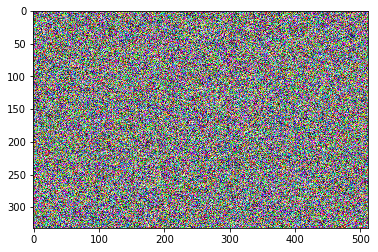

In [27]:
partial_image = tools._del_dim(tools._load_image(medellin_path))
h,w,c =  partial_image.shape
random_image =np.random.rand(h, w, c) * 255
init_image = np.clip(random_image, 0 ,255).astype('uint8')
plt.imshow(init_image)
plt.show()

Posteriormente esta imagmen tambien pasara por la red neural, por tanto, debemos preprocesar sus datos.


In [28]:
init_image = tf.keras.applications.vgg19.preprocess_input(tools._add_dim(init_image))

Dicha imagen la incluiremos dentro de tensorflow como una variable, la cual, cambiara sus datos mediante un proceso de optimizacion. Notese que usamos tfe.Variable en vez de tf.Variable, esto para usar la variable en modo Eager Execution.

In [29]:
init_image = tfe.Variable(init_image, dtype=tf.float32)
print(init_image)

<tf.Variable 'Variable:0' shape=(1, 332, 512, 3) dtype=float32, numpy=
array([[[[ 141.061    ,    3.2210007,  -70.68     ],
         [  92.061    ,   63.221    ,   35.32     ],
         [ -28.939003 ,  -42.779    ,  -29.68     ],
         ...,
         [   6.060997 ,  108.221    ,  -10.68     ],
         [  21.060997 ,  -74.779    ,   76.32     ],
         [  20.060997 ,  -65.779    ,  -26.68     ]],

        [[ -45.939003 ,   41.221    ,  -10.68     ],
         [ -37.939003 ,  -88.779    ,   93.32     ],
         [  25.060997 ,   50.221    , -106.68     ],
         ...,
         [  45.060997 , -116.779    ,  -81.68     ],
         [ -90.939    ,   62.221    ,   76.32     ],
         [ 131.061    ,   81.221    ,  119.32     ]],

        [[ 114.061    , -111.779    ,   20.32     ],
         [  32.060997 ,  -27.779    ,  -22.68     ],
         [  31.060997 ,   23.221    ,  -26.68     ],
         ...,
         [ -42.939003 ,   99.221    ,  -51.68     ],
         [  32.060997 ,  -68.779   

<h3>Optimizador</h3>

El documento original expone que podemos usar cualqueir tipo de  optimizacion. En el articulo se recomienda utilizar la optimizacion BFGS. Siguiendo el blog de tensorflow notamos que usaban adam y tenian muy buenos resultados. Queda como trabajo futuro incorporar la optimizacion mediante BFGS

In [30]:
opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)


<h3>Computo de grandientes, Perdidas de estilo y  contentido</h3>

Ahora, las funciones de costo tanto para el estilo como para el contenido estan basadas en la distancia euclidiana.
Para el estilo podemos observar dos versiones donde varia el denominador.

In [36]:
# Version del articulo
def style_loss(generated_style, gram_target):

    height, width, channels = generated_style.get_shape().as_list()
    gram_generated_style = gram_matrix(generated_style)
    den =  (4. * (channels ** 2) * (width * height) ** 2)
    return tf.reduce_mean(tf.square(gram_generated_style - gram_target))/den

In [37]:
# Version blog de tensorflow
def style_loss(generated_style, gram_target):
    height, width, channels = generated_style.get_shape().as_list()
    gram_generated_style = gram_matrix(generated_style)
    return tf.reduce_mean(tf.square(gram_generated_style - gram_target))

Fijemonos, que en el metodo <i>style_loss</i> como parametros entra generated_style que es una de las capas de la imagen generada. Por su parte <i>gram_target</i> se refiere a la misma capa, esta vez, de la imagen de estilo.

Para la perdida de contenido se usa la distancia euclidiana de la capa <b><i>conv5_2</i></b> de la imange generada contra la imagen de contenido

In [39]:
def content_loss(generated, content):
    return tf.reduce_mean(tf.square(generated - content))

El costo total sera la suma de la perdida de estilo mas el contenido.(En el paquete dst implementamos una perdida adicional llamada perdida de variacion y es util para dar un estilo mas suave a la imagen generada.  ) 

Para actualizar la imagen generda se calcula el gradiente de dicha imagen respecto a la perdida total. Para hacer uso de la diferenciacion automatica de tensorflow debemos hacer una traza de la funcion de costo y asi aplicar el gradiente a la imagen generada. Hacer el rastreo de la funcion  es posible mendiante el uso de <i>tf.GradientTape()</i> y el calculo del gradiente mediante <i>tape.gradient(total_loss, init_image)</i>.

Luego, lo que queda sera actualizar el tensor que contiene la imagen con dichos gradientes.
Las ideas hasta aqui expuestas se mostraran en un ejemplo a continuacion.

<h3>Transferencia de estilo paso por paso</h3>

Combinemos la imagen de Medellin junto al estilo de Van Goht. Se usaran funciones del paquete <b><i>dst</i></b> para simplificar algunas lineas de codigo. Todo el codigo puede encontarlo en este <a href="https://github.com/cactusAi/DeepStyleTransfer">repositorio</a>.

In [114]:
content_path = "../images/medellin.jpg"
style_path = "../images/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

style_weight, content_weight = 1e-2, 1e3

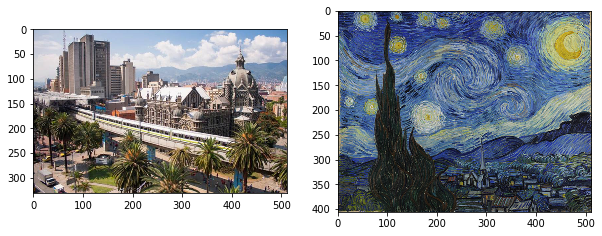

In [97]:
# Cargamos las imagenes
content = dst.tools._load_and_process_img(content_path)
style = dst.tools._load_and_process_img(style_path)

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(dst.tools.deprocess_img(content))
plt.subplot(1, 2, 2)
plt.imshow(dst.tools.deprocess_img(style))

332 512 3


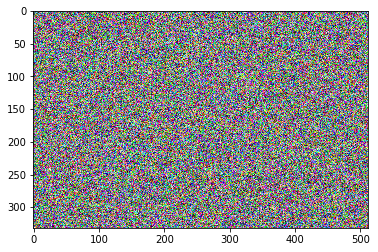

In [98]:
# Generemos la imagen a la que sera nuestro lienzo.
l, h, w, c  = content.shape
print(h,w,c)
random_image = np.random.rand(h,w,c) * 255
init_image = np.clip(random_image, 0 ,255).astype('uint8')
plt.imshow(init_image)

#Init_image en formato VGG19
init_image = tf.keras.applications.vgg19.preprocess_input(dst.tools._add_dim(init_image))

# Se crea la variable para la imagen inicial
init_image = tfe.Variable(init_image, dtype=tf.float32)



In [99]:
#Obtenemos el modelo
CONTENT_LAYERS_LIST = ['block5_conv2']
STYLE_LAYERS_LIST = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1']
model = dst.dst.get_model(CONTENT_LAYERS_LIST, STYLE_LAYERS_LIST)

In [100]:
#Definimos el optimizador
opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

In [101]:
# Obtenemos los mapas de caracteristicas para la imgen de contenido y el estilo.
style_features, content_features = dst.dst._get_feactuere_maps(model, content_path, style_path, len(STYLE_LAYERS_LIST))

In [102]:
# Para cada capa de STYLE_LAYER_LIST calcularemos la matrix gram
gram_style_features = [losses.gram_matrix(style_feature) for style_feature in style_features]

La siguiente funcion realiza un proceso iterativo entre los arreglos CONTENT_LAYERS_LIST y STYLE_LAYERS_LIST.
Dicho proceso se raliza en las lineas <i>24</i> a <i>27</i> para el estilo y <i>31</i> a <i>34</i> para el contenido.
Los erroes se acumulan en una variable y luego se suman (linea <i>42</i>)

In [103]:
# Para computar la perdida lo realizaremos mediante la siguiente funcion, Notese que agregamos una funcion de 
# costo adicional variation_weight, por el momento la asignaremos en 0
def compute_loss(model, loss_weights, init_image, gram_style_features,
                 content_features, num_style_layers):

    style_weight, content_weight, variation_weight = loss_weights
    
    # Feed our init image through our model. This will give us the content and
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0
    variation_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)

    for target_style, comb_style in zip(gram_style_features,
                                        style_output_features):
        style_score += weight_per_style_layer * \
            style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers
    weight_per_content_layer = 1.0 / float(1)
    for target_content, comb_content in zip(content_features,
                                            content_output_features):
        content_score += weight_per_content_layer * \
            content_loss(comb_content[0], target_content)

    variation_score = total_variation_loss(init_image)

    style_score *= style_weight
    content_score *= content_weight
    variation_score *= variation_weight
    # Get total loss
    loss = style_score + content_score + variation_score
    return loss, style_score, content_score, variation_score


Luego, daremos los valores respectivos para obtener la perdida total pero realizando un rastreo del gradiente de este.

In [104]:

with tf.GradientTape() as tape:
    # Seguimos la traza de la funcion perdida
    all_loss = losses.compute_loss(model, (style_weight,content_weight,0), init_image, gram_style_features, content_features,len(STYLE_LAYERS_LIST))
# Compute gradients wrt input image
total_loss = all_loss[0] # all_loss[0] es la suma de los errores de estilo y contenido, es decir la perdida total
gradients = tape.gradient(total_loss, init_image)
print(gradients)

tf.Tensor(
[[[[-2.01860924e+01 -1.80354004e+02  1.25352478e+00]
   [-6.28202972e+01 -3.03965851e+02 -2.49887009e+01]
   [ 4.53115326e+02  1.65866440e+02  4.40033600e+02]
   ...
   [-8.14650879e+01 -4.12233002e+02 -1.68699341e+02]
   [ 2.47376221e+02  2.07906357e+02  3.71059387e+02]
   [ 2.76364136e+01  8.11023178e+01  1.43406845e+02]]

  [[ 1.79524658e+02 -3.18255882e+01  1.88144073e+02]
   [ 2.64981140e+02 -5.84666786e+01  2.37925903e+02]
   [ 8.45166382e+02  3.30215454e+02  6.37098267e+02]
   ...
   [-3.77174835e+02 -1.11215747e+03 -8.18815063e+02]
   [ 2.01766815e+02 -1.53365860e+01  2.15421875e+02]
   [-1.81296097e+02 -1.99869843e+02 -7.09644165e+01]]

  [[ 8.96861420e+01 -8.02824860e+01 -2.77611961e+01]
   [ 2.91945740e+02  5.71746826e-01 -2.94970703e+00]
   [ 7.47091553e+02  8.23440704e+01  1.51732574e+02]
   ...
   [ 5.16054749e+02 -3.63417908e+02 -3.53974091e+02]
   [ 9.90961182e+02  6.76475159e+02  7.26353638e+02]
   [ 1.45632233e+02  6.01107254e+01  1.33727448e+02]]

  ...

 

De esta forma tenemos los gradientes de nuestra imagen lienzo respecto al estilo y contenido deseado. Realizaremos un paso en la optimizacion.

In [105]:
opt.apply_gradients([(gradients, init_image)])

Sin embargo, puede que algunos valores esten fuera de rango. Recordemos que esta imagen esta representada en formato VGG19.

In [106]:
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
updated_image_clipped = tf.clip_by_value(init_image, min_vals, max_vals)

Ahora, asignaremos estos nuevos valores a la variable(tensor) init_image

In [107]:
init_image.assign(updated_image_clipped)

<tf.Variable 'UnreadVariable' shape=(1, 332, 512, 3) dtype=float32, numpy=
array([[[[ 111.3838   ,  -27.865158 ,  -12.099357 ],
         [ -48.178635 ,  -42.830482 ,    3.7583327],
         [ 132.09566  ,  -83.685455 ,   89.355675 ],
         ...,
         [  98.87416  ,  -30.817062 ,  -35.772003 ],
         [ -80.87589  ,  111.29591  ,   89.36225  ],
         [ 142.57439  ,    3.4086409,  -66.57212  ]],

        [[ 113.147545 ,  -51.23091  ,   95.40265  ],
         [   7.1199636,  -14.035559 ,   83.38558  ],
         [ 114.079636 ,  -42.73157  ,   93.344696 ],
         ...,
         [ -15.980576 , -106.793175 ,  -63.699238 ],
         [-101.86185  ,   40.366272 ,  102.392334 ],
         [ -83.02472  ,    2.1431246,   40.106697 ]],

        [[  28.23129  ,  -69.96848  ,  103.80869  ],
         [  26.114576 ,   18.455414 ,  -20.266956 ],
         [  97.08207  ,   37.405914 ,   30.422077 ],
         ...,
         [  83.091446 ,   70.17787  ,  -19.724274 ],
         [  95.076904 ,   58.24

Veamos como luce nuestra imagen. Convertimos nuestro tensor a una estructura numpy y luego realizamos el proceso inverso para conertir el tensor que esta en formato vgg19 a formato RGB(0-255)

In [108]:
partial_image =  dst.tools.deprocess_img(init_image.numpy())

Miremos como luce!

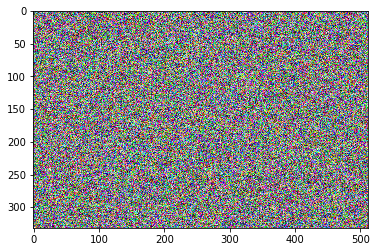

In [109]:
plt.imshow(partial_image)

Aparentemente no ocurrio nada, vamos a realizar los pasos anteriores de manera iterativa.

In [110]:
for i in range(10):
    with tf.GradientTape() as tape:
        # Seguimos la traza de la funcion perdida
        all_loss = losses.compute_loss(model, (style_weight,content_weight,0), init_image, gram_style_features, content_features,len(STYLE_LAYERS_LIST))
    # Compute gradients wrt input image
    total_loss = all_loss[0] # all_loss[0] es la suma de los errores de estilo y contenido, es decir la perdida total
    gradients = tape.gradient(total_loss, init_image)
    opt.apply_gradients([(gradients, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)

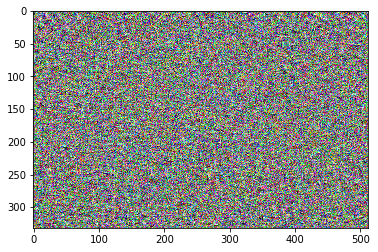

In [111]:
partial_image =  dst.tools.deprocess_img(init_image.numpy())
plt.imshow(partial_image)

iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900


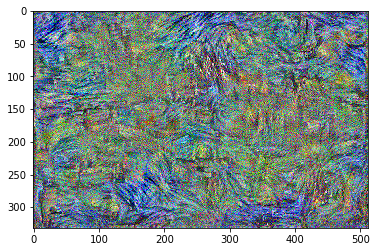

In [112]:
for i in range(1000):

    with tf.GradientTape() as tape:
        # Seguimos la traza de la funcion perdida
        all_loss = losses.compute_loss(model, (style_weight,content_weight,0), init_image, gram_style_features, content_features,len(STYLE_LAYERS_LIST))
    # Compute gradients wrt input image
    total_loss = all_loss[0] # all_loss[0] es la suma de los errores de estilo y contenido, es decir la perdida total
    gradients = tape.gradient(total_loss, init_image)
    opt.apply_gradients([(gradients, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    if i % 100 == 0:
        print("iter:", i )
partial_image =  dst.tools.deprocess_img(init_image.numpy())
plt.imshow(partial_image)

Podemos obsevar como luego de muchas iteraciones la imagen lienzo empieza a adquirir el estilo y contenido de las imagenes que deseabamos. Experimentos nos mostraran que si iniciamos la imagen lienzo como la imagen de contenido, el resultado presenta versiones mas estables en menos iteraciones.

De esta manera es como funciona la tecnica de transferencia de estilo. 
Miremos como realizar este proceso con el paquete dst.

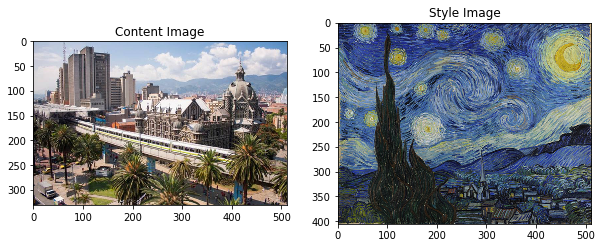

In [115]:
plt.figure(figsize=(10,10))

content = tools._load_image(content_path).astype('uint8')
style = tools._load_image(style_path).astype('uint8')

plt.subplot(1, 2, 1)
tools.imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
tools.imshow(style, 'Style Image')
plt.show()

In [117]:
st = dst.dst()

Python version: 3.6
TensoFlow version:  1.13.1
Keras version:  2.2.4-tf


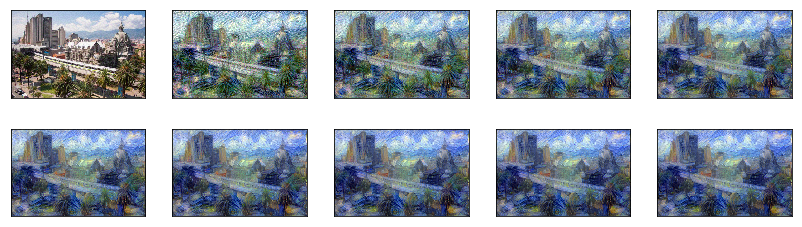

In [118]:
best, best_loss = st.tranfer_style(content_path, 
                                     style_path, num_iter=1000, variation_weight=0.001)

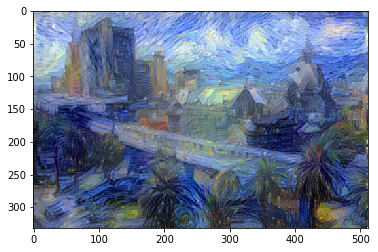

In [121]:
 plt.imshow(best)